# Lorenzo Cassano 
## Importing Libraries

In [128]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from matplotlib import cm
from sklearn.metrics import classification_report

%matplotlib inline

random_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

# the .py files with the functions provided must be in the same directory of the .ipynb file

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1 Load Data

In [130]:
#data_file = '/content/drive/MyDrive/ML/Data/exam_superv.csv'
data_file = 'dataset1.csv'
delimiter = ','
df = pd.read_csv(data_file, sep = ',')

### Inspect

In [131]:
df.shape

(1200, 4)

In [132]:
df.head()

,0,1,y,2
0,1.589942,2.977770,0,1.953805
1,2.908437,1.837522,1,1.510049
2,3.284091,1.818476,1,3.307287
3,3.148717,2.071991,1,3.452021
4,2.116881,2.133874,0,2.157870


In [133]:
X = df.drop("y", axis = 1)
y = df["y"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f849bd20790>,
      dtype=object)

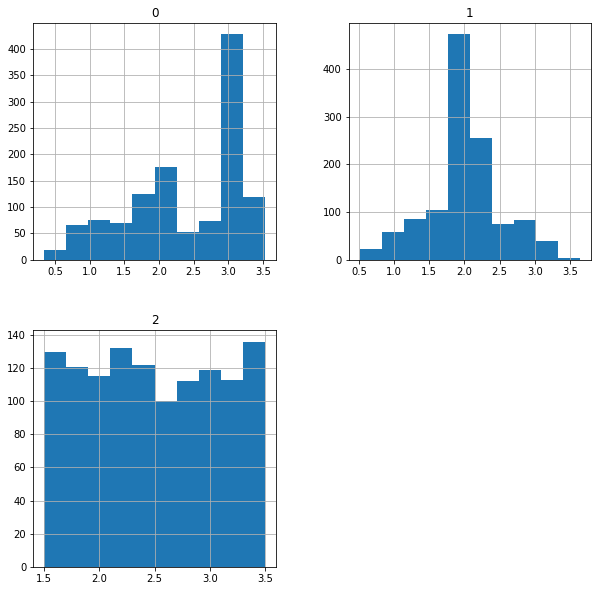

In [134]:
X.hist(figsize = [10,10])

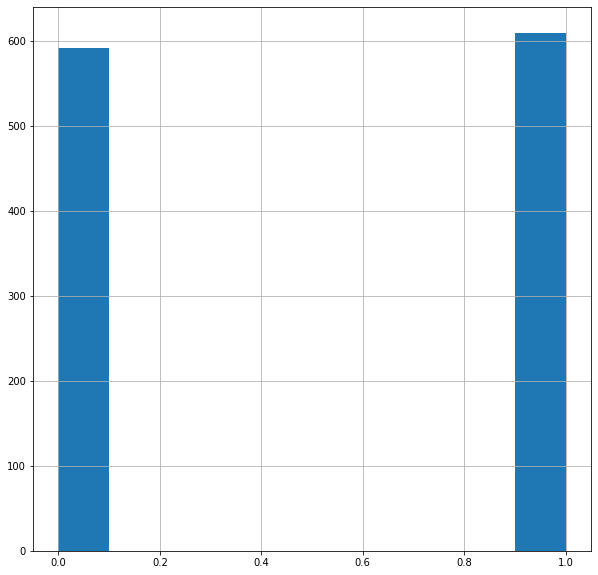

In [135]:
y.hist(figsize = [10,10])

## Some description

In [136]:
X.describe()

,0,1,2
count,1200.000000,1200.000000,1200.000000
mean,2.391668,1.996186,2.494236
std,0.804770,0.507227,0.589235
min,0.343023,0.509424,1.500260
25%,1.806657,1.809635,1.974389
50%,2.744439,1.983524,2.469778
75%,3.092275,2.201484,2.995198
max,3.529782,3.647299,3.498523


In [137]:
y.describe()

count    1200.000000
mean        0.507500
std         0.500152
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: y, dtype: float64

## 2 Find best clustering scheme


### Dropping column with little correlation on y

In [138]:
focus = [0,1]
X = X.drop("2", axis = 1)
X.head()

,0,1
0,1.589942,2.977770
1,2.908437,1.837522
2,3.284091,1.818476
3,3.148717,2.071991
4,2.116881,2.133874


In this simple example you can easily see which are the two most interesting columns.

All the plots will focus on those columns

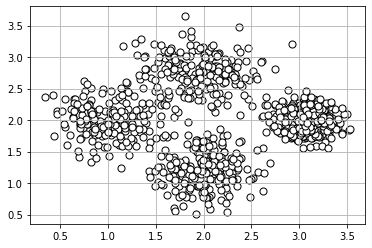

In [139]:
X = np.array(X)
plt.scatter(X[:,focus[0]], X[:,focus[1]]
            , c='white'          # color filling the data markers
            , edgecolors='black' # edge color for data markers
            , marker='o'         # data marker shape, e.g. triangles (v<>^), square (s), star (*), ...
            , s=50)              # data marker size
plt.grid()  # plots a grid on the data
plt.show()

### Try to use k-means
First consideration:
goal is to find the best rappresentation on y 
In this case we do not need to find the parameter k = number of cluster
Parameter k = 2 in this case
So for the k-means the best model is with k = 2

In [140]:
# help(plot_clusters)
def plot_clusters(X, y, dim, points,
                  labels_prefix = 'cluster', 
                  points_name = 'centroids',
                  colors = cm.tab10, # a qualitative map 
                      # https://matplotlib.org/examples/color/colormaps_reference.html
#                   colors = ['brown', 'orange', 'olive', 
#                             'green', 'cyan', 'blue', 
#                             'purple', 'pink'],
#                   points_color = 'red'
                  points_color = cm.tab10(10) # by default the last of the map (to be improved)
                 ):
    """
    Plot a two dimensional projection of an array of labelled points
    X:      array with at least two columns
    y:      vector of labels, length as number of rows in X
    dim:    the two columns to project, inside range of X columns, e.g. (0,1)
    points: additional points to plot as 'stars'
    labels_prefix: prefix to the labels for the legend ['cluster']
    points_name:   legend name for the additional points ['centroids']
    colors: a color map
    points_color: the color for the points
    """
    # plot the labelled (colored) dataset and the points
    labels = np.unique(y)
    for i in range(len(labels)):
        color = colors(i / len(labels)) # choose a color from the map
        plt.scatter(X[y==labels[i],dim[0]], 
                    X[y==labels[i],dim[1]], 
                    s=10, 
                    c = [color], # scatter requires a sequence of colors
                    marker='s', 
                    label=labels_prefix+str(labels[i]))
    plt.scatter(points[:,dim[0]], 
                points[:,dim[1]], 
                s=50, 
                marker='*', 
                c=[points_color], 
                label=points_name)
    plt.legend()
    plt.grid()
    plt.show()

In [141]:
def compute_centroids(X, y, n_clusters):
  centroids = np.empty((n_clusters, X.shape[1]))
  for i in range(0, n_clusters):
    centroids[i, :] = np.mean(X[y == i], axis = 0)
  return centroids

In [142]:
k = 2
km_model =  KMeans(n_clusters= k, random_state = random_state)
y_km = km_model.fit_predict(X)
print("Number of clusters {}, silhouette {:4.2f}".format(k, silhouette_score(X, y_km)))

Number of clusters 2, silhouette 0.56


### Plotting clusters of K-means

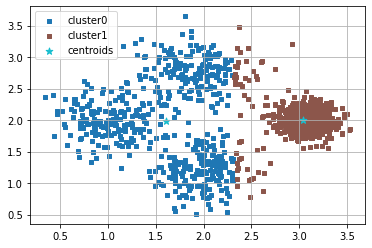

In [143]:
centroids = compute_centroids(X, y_km, n_clusters = k)
plot_clusters(X, y_km, dim=(focus[0],focus[1]), points = centroids)

### Plotting clusters of dataset

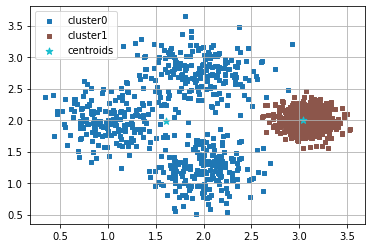

In [144]:
centroids_dataset = compute_centroids(X, y, n_clusters = k)
plot_clusters(X, y, dim=(focus[0],focus[1]), points = centroids)

It is possible observe that k-means does not work well with a number of cluster = 2

### Try to use Dbscan

In [145]:
tuned_param_dbbscan = {'eps': list(np.arange(0.01, 1, 0.01)), 'min_samples': list(range(1,10)) }
params = list(ParameterGrid(tuned_param_dbbscan))

In [146]:
dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])
for i in range(len(params)):
    db = DBSCAN(**(params[i]))
    y_find = db.fit_predict(X)
    
    cluster_labels_noise = np.unique(y_find)
    cluster_labels = cluster_labels_noise[cluster_labels_noise != -1]
    n_clusters = len(cluster_labels)

    if n_clusters > 1:
        X_cl = X[y_find != -1, :]
        y_find_cl = y_find[y_find != -1]
        silhouette = silhouette_score(X_cl, y_find_cl)
        uncl_p = (1 - y_find_cl.shape[0] / y_find.shape[0]) * 100
        dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]

In [147]:
sil_thr = 0.56  # visualize results only for combinations with silhouette above the threshold
unc_thr = 10 # visualize results only for combinations with unclustered% below the threshold
#dbscan_out[(dbscan_out['silhouette'] >= sil_thr) & (dbscan_out['unclust%'] <= unc_thr)]
dbscan_out[(dbscan_out['silhouette'] >= sil_thr) & \
          (dbscan_out['unclust%'] <= unc_thr) & \
          (dbscan_out['n_clusters'] <= k)]

,eps,min_samples,n_clusters,silhouette,unclust%
121,0.15,4.0,2.0,0.571673,2.666667
130,0.16,4.0,2.0,0.566636,1.750000
131,0.16,5.0,2.0,0.569389,2.250000
138,0.17,4.0,2.0,0.563942,1.333333
139,0.17,5.0,2.0,0.566375,1.666667
146,0.18,4.0,2.0,0.561564,1.083333
147,0.18,5.0,2.0,0.562483,1.250000
148,0.18,6.0,2.0,0.566400,1.750000
154,0.19,6.0,2.0,0.563013,1.416667
155,0.19,7.0,2.0,0.565904,1.750000


The best hyperparameter for DBSCAN is eps = 0.18 min_samples = 4

In [155]:
min_eps = 0.18
samples = 4
dbscan_model = DBSCAN(eps= min_eps, min_samples= samples)
y_dbscan = dbscan_model.fit_predict(X)
n_clusters = len(cluster_labels)
cluster_labels_noise = np.unique(y_dbscan)
cluster_labels = cluster_labels_noise[cluster_labels_noise != -1]
centroids = compute_centroids(X, y_dbscan,n_clusters)
print("There are {} clusters ".format(n_clusters))


There are 2 clusters 


### Plotting cluster of dbscan

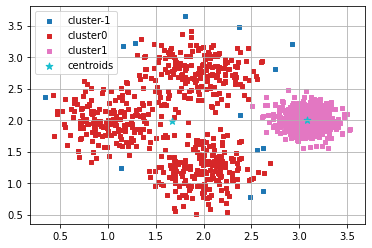

In [149]:
centroids = compute_centroids(X, y_dbscan, n_clusters = k)
plot_clusters(X, y_dbscan, dim=(focus[0],focus[1]), points = centroids)

### It is possible to observe that Dbscan is able to do a good prediction

## Evaluation with gold standard

In [150]:
from sklearn.metrics import pair_confusion_matrix
pcm = pair_confusion_matrix(y, y_dbscan)
print("Confusion Matrix\n", pcm)
print()
print("Normalized Confusion Matrix")
print(pcm / pcm.sum())

Confusion Matrix
 [[716184   3654]
 [ 18478 700484]]

Normalized Confusion Matrix
[[0.4977648  0.00253962]
 [0.01284265 0.48685293]]


In [151]:
print("The percentage of match between the two clustering schemes is {:6.2f}%".format((pcm / pcm.sum()).diagonal().sum()*100))

The percentage of match between the two clustering schemes is  98.46%


## 4 Try to use the same trasformation, clustering and hyperparamete on an other dataset

In [152]:
data_file = 'dataset2.csv'
delimiter = ','
df2 = pd.read_csv(data_file, sep = ',')

In [153]:
df2.head()

,0,1,2
0,3.185684,2.208597,3.045639
1,2.179220,1.410352,2.396246
2,2.242676,2.624663,2.833286
3,1.980176,0.836695,2.188114
4,3.210992,2.251962,3.309826


In [154]:
X2= df2.drop("2", axis = 1)
X2.head()

,0,1
0,3.185684,2.208597
1,2.179220,1.410352
2,2.242676,2.624663
3,1.980176,0.836695
4,3.210992,2.251962


In [157]:
dbscan_model = DBSCAN(eps= min_eps, min_samples= samples)
y_dbscan1 = dbscan_model.fit_predict(X2)

cluster_labels_noise = np.unique(y_dbscan1)
cluster_labels = cluster_labels_noise[cluster_labels_noise != -1]
n_clusters = len(cluster_labels)
centroids = compute_centroids(X2, y_dbscan1,n_clusters)
print("There are {} clusters ".format(n_clusters))

There are 1 clusters 


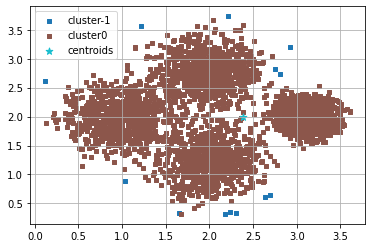

In [158]:
centroids = compute_centroids(X2, y_dbscan1, n_clusters = k)
plot_clusters(np.array(X2), y_dbscan1, dim=(focus[0],focus[1]), points = centroids)

We can observe that this clustering does not work well in this dataset